## Guided Project: Investigating Fadango Movie Ratings

In October 2015, Walt Hickey from FiveThirtyEight published [a popular article](https://fivethirtyeight.com/features/fandango-movies-ratings/) where he presented strong evidence which suggest that Fandango's movie rating system was biased and dishonest. In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

### Understanding the data
We'll work with two samples of movie ratings:the data in one sample was collected previous to Hickey's analysis, while the other sample was collected after. Let's start by reading in the two samples (which are stored as CSV files) and getting familiar with their structure.

In [6]:
import pandas as pd
walt_df = pd.read_csv('fandango_score_comparison.csv') # previous Hickey's analysis
dq_df = pd.read_csv('movie_ratings_16_17.csv') # after Hickey's analysis

before = walt_df[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
after = dq_df[['movie', 'year', 'fandango']].copy()

In [7]:
before.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [8]:
after.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


Our goal is to determine whether Fandango's rating system changed or not after Hickey's anaylsis. The population of interest is made of all the movie ratings listed in Fandango's platform regardless of releasing year and popularity. 

Because we want to figure out the parameters of this population changed after Hickey's analysis. We're interested in sampling the population at two different periods in time - previous and after Hickey's analysis - so we can compare the two states.

The two datasets we're working with were sampled at different moments. (one was sampled before the analysis and the other was sampled after the analysis) We want to describe the population, so we need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions. 

From Hickey's article and from the README.md of [the data set's repository](https://github.com/fivethirtyeight/data/tree/master/fandango), we can see that he used the following sampling criteria.
- The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug 24, 2015) 
- The movie must have had tickets on sale in 2015.

The sampling was clearly not random because not every movie had the same chance to be included in the sample - some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends - e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of [the data set's repository](https://github.com/mircealex/Movie_ratings_2016_17)):
- The movie must have been relaesed in 2016 or later
- The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data)

Just as the first sampling, this second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest. 

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgemental/ selective/ subjective sampling). While these samples were good enough to their research, they don't seem too useful for us.

### Changing the goal of our analysis
At this point, we can either collect new data or change our goal of our analysis. We choose the latter and place some limitations on our initial goal. 

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be faily good proxy for our initial goal.

### Isolating the samples we need

With the new research goal we have two populations of interest:
- The popular movies in Fandango platform released in 2015
- The popular movies in Fandango platform released in 2016

First of all, let's check the data sets before analysis. We can verify it by examining the 'Fandango_vote's column

In [9]:
sum(before['Fandango_votes']<30)

0

The before data set is verified. On the other hand the after dataset doesn't contain information regarding to popularity. One quick way to check the data set's representativity is to randomly sample 10 movies and then check those movies in the Fandango's website manually. 

In [10]:
after_sample = after.sample(10, random_state=1)
after_sample

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


In [11]:
after_sample['nr_ratings'] = pd.Series(data=[
    25617,
    31552,
    6827,
    30639,
    87852,
    3817,
    2885,
    48482,
    10216,
    179930], index=after_sample.index)
after_sample

,movie,year,fandango,nr_ratings
108,Mechanic: Resurrection,2016,4.0,25617
206,Warcraft,2016,4.0,31552
106,Max Steel,2016,3.5,6827
107,Me Before You,2016,4.5,30639
51,Fantastic Beasts and Where to Find Them,2016,4.5,87852
33,Cell,2016,3.0,3817
59,Genius,2016,3.5,2885
152,Sully,2016,4.5,48482
4,A Hologram for the King,2016,3.0,10216
31,Captain America: Civil War,2016,4.5,179930


Because of the absence of information about the number of reviews in Fandango's website, we refered to the Rottentomatoes website which is already linked. Every movie in the sample has more than 30 reviews therefore, the popularity is verified.

Now Let's check the year.

In [12]:
before['year'] = before['FILM'].str[-5:-1]
before['year'].value_counts()

2015    129
2014     17
Name: year, dtype: int64

In [13]:
after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

As you can see in before dataset there are movies which were created not in 2015 and in after dataset there are movies which were created not in 2016. Let's isolate them according to our interest

In [14]:
before_final = before[before['year']=='2015'].copy()
before_final

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015
5,The Water Diviner (2015),4.5,4.0,397,0.5,2015
6,Irrational Man (2015),4.0,3.5,252,0.5,2015
8,Shaun the Sheep Movie (2015),4.5,4.0,896,0.5,2015
9,Love & Mercy (2015),4.5,4.0,864,0.5,2015
10,Far From The Madding Crowd (2015),4.5,4.0,804,0.5,2015


In [15]:
after_final = after[after['year']==2016].copy()
after_final

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
4,A Hologram for the King,2016,3.0
5,A Monster Calls,2016,4.0
6,A Street Cat Named Bob,2016,4.5
7,Alice Through the Looking Glass,2016,4.0
8,Allied,2016,4.0
9,Amateur Night,2016,3.5
10,Anthropoid,2016,4.0


### Comparing distribution shapes for 2015 and 2016
Our aim is to figure out if there is any difference between ratings between 2015 popular movies and 2016 popular movies. One of the way to do that is to inspect the shape of rating distribution 

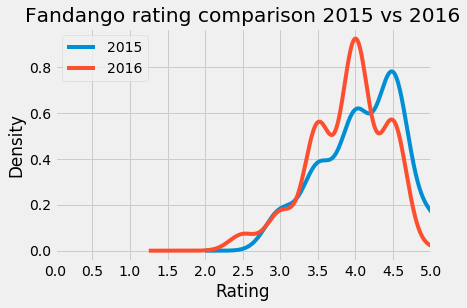

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.style.use('fivethirtyeight')
before_final['Fandango_Stars'].plot(kind='kde', label='2015', legend=True)
after_final['fandango'].plot(kind='kde', label='2016', legend=True)
plt.title('Fandango rating comparison 2015 vs 2016')
plt.xlabel('Rating')
plt.xlim(0,5)
plt.xticks(np.arange(0,5.1,step=0.5))
plt.show()

Two aspects are striking on the figure above. 
- Both distributions are strongly left skewed
- The 2016 distribution is slightly left shifted than 2015

The left skewed suggests that movies on Fandango are given mostly high and very high fan ratings (4.5 and 5). Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further - ideally in a seperate project, since this is quite irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratins for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.

### Comparing Relative Frequencies
It seems we're following a good thread so far, but we need to analyze more granular information. Let's examine the frequency tables of the two distributions to analyze some numbers. Because the data sets have different numbers of movies, we normalize the tables and show percentages instead.

In [17]:
print('2015' + '\n' + '-'*16)

before_final['Fandango_Stars'].value_counts(normalize=True).sort_index()*100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [18]:
print('2016' + '\n' + '-'*16)

after_final['fandango'].value_counts(normalize=True).sort_index()*100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high ratings(4.5 and 5) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 - there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 - 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

### Determining the direction of the change
Let's take a couple of summary metrics to get a more precise picture about the direction of the change. In what follows, we'll compute the mean, the median, and the mode for both distributions and then use a bar graph to plot the values.

In [19]:
mean_2015 = before_final['Fandango_Stars'].mean()
median_2015 = before_final['Fandango_Stars'].median()
mode_2015 = before_final['Fandango_Stars'].mode()[0]

mean_2016 = after_final['fandango'].mean()
median_2016 = after_final['fandango'].median()
mode_2016 = after_final['fandango'].mode()[0]

summary = pd.DataFrame(data={'mean':[mean_2015, mean_2016], 'median':[median_2015, median_2016], 'mode':[mode_2015, mode_2016]}, index=['2015','2016'])
t_summary = summary.transpose()
t_summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


As you can see the table above, from 2015 to 2016, the mean value dropped from 4.09 to 3.89 and the mode value changed from 4.5 to 4.0

Let's visulaize them so that we can notice the difference better

Text(0.5, 1.0, 'Summary statistics 2015 vs 2016')

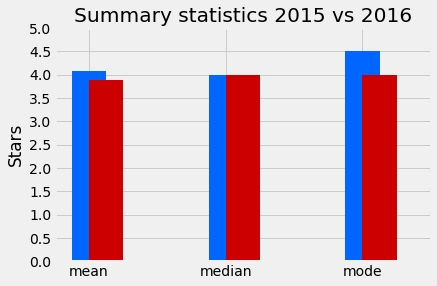

In [20]:
plt.style.use('fivethirtyeight')
t_summary['2015'].plot(kind='bar', color='#0066FF', align='center', width=.25)
t_summary['2016'].plot(kind='bar', color='#CC0000', align='edge', width=.25)
plt.xticks(rotation=0)
plt.yticks(np.arange(0,5.5,step=0.5))
plt.ylabel('Stars')
plt.title('Summary statistics 2015 vs 2016')


We can see the differecne clearly with the graph above. The mean rating was lower in 2016 with approximately 0.2. This means a drop was almost 5% relative to the mean rating in 2015.

In [21]:
(t_summary.loc['mean'][0] - t_summary.loc['mean'][1]) / t_summary.loc['mean'][0]

0.04842683568951993

### Conclusion

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015. 

We cannot be completely sure what caused the cange, but the chances are very high that it was caused by Fandango fixing the biased system after Hickey's analysis.